In [1]:
import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from src.datagenerator import DataGenerator, DataLoader, z_score
from src.performance_evaluation import compute_PCA, plot_confusion_matrix, plot_PCA
from src.util import plot_voxel

# load vae model
from src.vae import vae_model

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

2024-05-03 06:01:39.661524: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-03 06:01:40.819090: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
print(tf.__version__)

2.16.1


# Stage 2

**1. Training of the material classificator $\Upsilon$**

**2. Training of the mapper $\Xi$**

## Material classificator $\Upsilon$

### *i)* DNN

## *ii)* CNN

In [3]:
datagenerator = False

params = {
    "path": "../3dIT/measurements/datapool/",
    "mean_path": "../3dIT/measurements/datameans/",
    "eit_dim": 4096,
    "supervised": "material",  # "diameter" or "material"
    "batch_size": 128,
    "shuffle": True,
    "EIT_shape": "matrix",
}

if datagenerator:

    idx = np.arange(0, len(os.listdir(params["path"])))
    np.random.shuffle(idx)

    limit_index = 100_000

    training_generator = DataGenerator(idx[:limit_index], **params)
    test_____generator = DataGenerator(idx[limit_index:], **params)
    X, Y = training_generator[0]
else:
    X, Y = DataLoader(params, n_earlystop=50)
    X = z_score(X)
    X = np.expand_dims(X, axis=3)
    print(X.shape, Y.shape)

100%|██████████| 50/50 [00:01<00:00, 33.25it/s]

(50, 64, 64, 1) (50,)


In [4]:
print(X.shape, Y.shape)

(50, 64, 64, 1) (50,)


In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.5, random_state=42
)

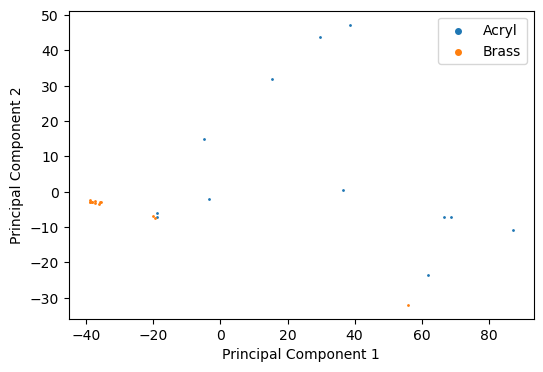

In [6]:
data_pca = compute_PCA(X_train)
plot_PCA(data_pca, Y_train)

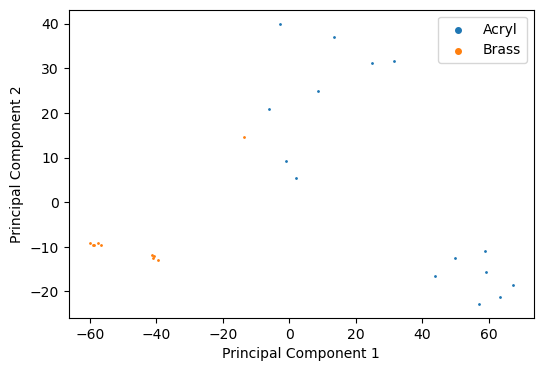

In [7]:
data_pca = compute_PCA(X_test)
plot_PCA(data_pca, Y_test)

In [8]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(25, 64, 64, 1) (25, 64, 64, 1) (25,) (25,)


In [37]:
def material_classificator_model_CNN(input_shape=(64, 64, 1), latent_dim=1, kernel=3):
    # optional aditional layer
    # x = MaxPooling2D(pool_size=(2,4))(x)
    # x = BatchNormalization()(x)
    # x = Activation("elu")(x)
    # x = Dropout(0.5)(x)

    mapper_input = tf.keras.layers.Input(shape=input_shape)
    # normalize input data
    # x = Xscaler(mapper_input)
    x = tf.keras.layers.Conv2D(8, kernel, strides=(2, 4), padding="same")(mapper_input)
    x = tf.keras.layers.Conv2D(8, kernel, strides=(2, 4), padding="same")(x)
    x = tf.keras.layers.Conv2D(16, kernel, strides=(2, 4), padding="same")(x)
    x = tf.keras.layers.Conv2D(16, kernel, strides=(2, 4), padding="same")(x)
    x = tf.keras.layers.Flatten()(x)
    # x = Dense(latent_dim, activation="elu")(x)
    mapper_output = tf.keras.layers.Dense(latent_dim, activation="linear")(x)

    return tf.keras.Model(mapper_input, mapper_output)


material_classificator_CNN = material_classificator_model_CNN()
material_classificator_CNN.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 16, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 4, 8)       │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 1, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 4, 1, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,217 (16.47 KB)

 Trainable params: 4,217 (16.47 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
material_classificator_CNN.compile(tf.optimizers.Adam(learning_rate=0.005), loss="mse")

In [39]:
if datagenerator:
    classificator_history_CNN = material_classificator_CNN.fit(
        training_generator, epochs=50, batch_size=128
    )
else:
    classificator_history_CNN = material_classificator_CNN.fit(
        X_train,
        Y_train,
        epochs=20,
        batch_size=params["batch_size"],
    )

Epoch 1/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0446
Epoch 2/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0021
Epoch 3/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0016
Epoch 4/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0014
Epoch 5/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0012
Epoch 6/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0011
Epoch 7/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0012
Epoch 8/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0012
Epoch 9/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 9.5717e-04
Epoch 10/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0010
Epoch 11/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8.6447e-04
Epoch 12/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 9.4666e-04
Epoch 13/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7.8411e-04
Epoch 14/20
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 8.7808e-04
Epoch 15/20
486/486 ━━━━━━━━━━━━━━━━━

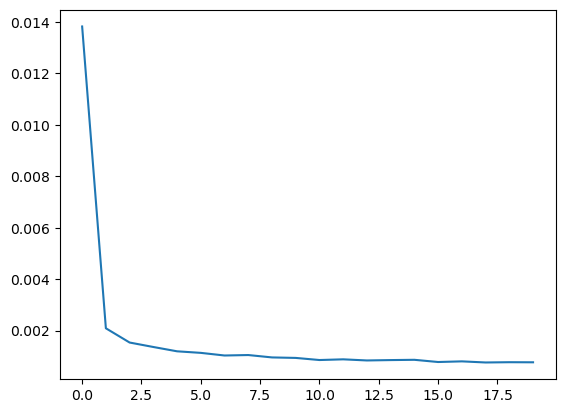

In [52]:
plt.plot(classificator_history_CNN.history["loss"])

In [41]:
Y_pred = np.concatenate(np.round(material_classificator_CNN.predict(X_test)))

1941/1941 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


In [43]:
s_path = "models/mapper_4/"

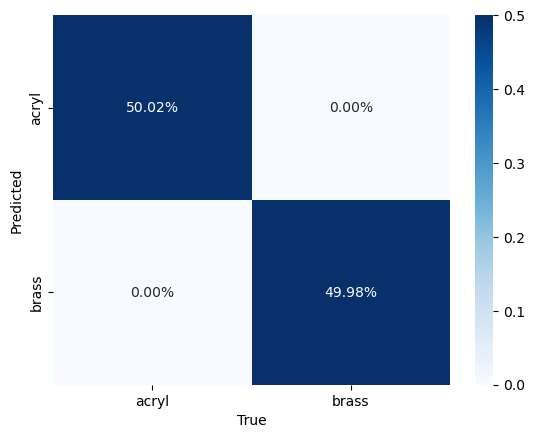

In [46]:
plot_confusion_matrix(Y_test, np.abs(Y_pred), s_path)

In [47]:
# os.mkdir(s_path)
material_classificator_CNN.save(f"{s_path}/model.keras")
np.savez(s_path + "/test_data.npz", X_test=X_test, Y_test=Y_test, params=params)

## Mapper $\Xi$

Loat the VAE model and train the two required mapper.

In [4]:
vae = vae_model()
vae.load_weights("models/vaes/vae_4.weights.h5")
vae.summary()

2024-05-03 06:02:59.937653: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46625 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:5e:00.0, compute capability: 8.6


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ VAE_encoder (Functional)        │ ?                      │        11,039 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ VAE_decoder (Functional)        │ ?                      │        11,467 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,506 (87.91 KB)

 Trainable params: 22,444 (87.67 KB)

 Non-trainable params: 62 (248.00 B)

In [5]:
params = {
    "path": "../3dIT/measurements/datapool/",
    "mean_path": "../3dIT/measurements/datameans/",
    "eit_dim": 4096,
    "EIT_shape": "matrix",
    "supervised": "anomaly",  # "diameter", "material", "anomaly"
    "batch_size": 128,
    "shuffle": True,
}

In [ ]:
X, Y = DataLoader(params)
X = z_score(X)
X = np.expand_dims(X, axis=3)
Y = np.expand_dims(Y, axis=4)

  6%|▌         | 7678/124200 [04:07<55:55, 34.72it/s]  

In [19]:
print(X.shape, Y.shape)

(124200, 64, 64, 1) (124200, 32, 32, 32, 1)


In [ ]:
z = np.empty((X.shape[0], 8, 1))
el_signals = np.empty((124200, 64, 64, 1))
gamma = np.empty((124200, 32, 32, 32, 1))

for n in range(len(training_generator)):
    X, y = next(training_generator)
    _, _, z = vae.encoder.predict(X)
    encodings[n * 100 : (n + 1) * 100, :, :] = np.expand_dims(z, axis=2)
    el_signals[n * 100 : (n + 1) * 100, :, :] = y
    reference[n * 100 : (n + 1) * 100, :, :] = X

## *i)* DNN

### *ii)* CNN

In [ ]:
Xscaler = tf.keras.layers.Normalization(axis=2)


def model(input_shape=(64, 64, 1), latent_dim=3, kernel=9):
    mapper_input = tf.keras.layers.Input(shape=input_shape)

    # normalize input data
    x = Xscaler(mapper_input)

    # convolutional layers
    x = tf.keras.layers.Conv2D(8, kernel, strides=(2, 4), padding="same")(x)
    # x = MaxPooling2D(pool_size=(2,4))(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Activation("elu")(x)
    # x = Dropout(0.5)(x)

    x = tf.keras.layers.Conv2D(8, kernel, strides=(2, 4), padding="same")(x)
    # x = MaxPooling2D(pool_size=(2,4))(x)
    # x = BatchNormalization()(x)
    # x = Activation("elu")(x)
    # x = Dropout(0.5)(x)

    x = tf.keras.layers.Conv2D(16, kernel, strides=(2, 4), padding="same")(x)
    # x = MaxPooling2D(pool_size=(2,4))(x)
    # x = BatchNormalization()(x)
    # x = Activation("elu")(x)
    # x = Dropout(0.5)(x)

    x = tf.keras.layers.Conv2D(16, kernel, strides=(2, 4), padding="same")(x)
    # x = MaxPooling2D(pool_size=(2, 4))(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = Activation("elu")(x)
    # x = Dropout(0.25)(x)

    x = tf.keras.layers.Flatten()(x)
    # x = Dense(latent_dim, activation="elu")(x)
    mapper_output = tf.keras.layers.Dense(latent_dim, activation="linear")(x)

    return tf.keras.Model(mapper_input, mapper_output)

In [13]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model = model(latent_dim=8, kernel=5)
model.compile(optimizer=opt, loss="mse")

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_1 (Normalization) │ (None, 64, 64, 1)      │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 16, 8)      │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 4, 8)       │         1,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 1, 16)       │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 1, 16)       │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,642 (45.48 KB)

 Trainable params: 11,513 (44.97 KB)

 Non-trainable params: 129 (520.00 B)

In [ ]:
# es = tf.keras.callback.EarlyStopping(
#    monitor="val_loss", mode="min", patience=10, restore_best_weights=True
# )
# Xscaler.adapt(X)

history = model.fit(training_generator, batch_size=128, epochs=10)

Epoch 1/10


/home/jath/.conda/envs/TF2_12/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-04-05 11:44:29.555552: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8
2024-04-05 11:44:48.093369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8


  1/781 ━━━━━━━━━━━━━━━━━━━━ 8:13:41 38s/step - loss: 0.5144

2024-04-05 11:44:52.602850: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


357/781 ━━━━━━━━━━━━━━━━━━━━ 40:06 6s/step - loss: 0.1372

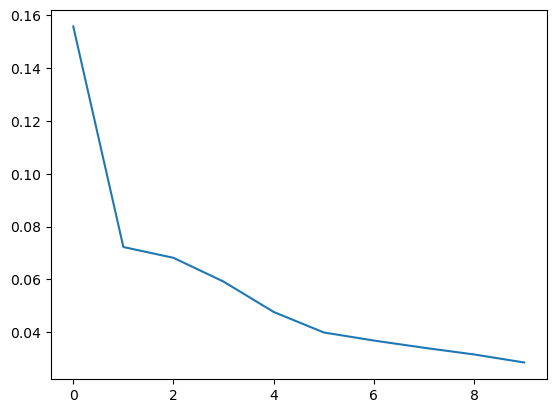

In [9]:
plt.plot(history.history["loss"])

In [11]:
model.save_weights("models/material_mapper.weights.h5")

## *iii)* Performance test

In [ ]:
training_generator = DataGenerator(idx[10_000:20_000], **params)